### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [41]:
from library.sb_utils import save_file

### Load Data

In [6]:
hosp_data = pd.read_csv('../data/main_df_post2_200.csv')
hosp_data.head()

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT,County_Facilities,Pop/Hosp
0,010001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,168.0,3.0,3.0,60.0,99.0,44661.000000,105882.0,40.0,2,52941.000
1,010005,BOAZ,AL,Marshall,764,14.7,1.650,1.055,2.780,0.601,...,139.0,2.0,4.0,60.0,93.0,37982.666667,96774.0,38.9,1,96774.000
2,010006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,182.0,1.0,3.0,32.0,82.0,38525.333333,92729.0,41.6,1,92729.000
3,010011,BIRMINGHAM,AL,Jefferson,918,16.3,0.424,0.993,0.802,0.359,...,174.0,3.0,3.0,30.0,76.0,56600.000000,658573.0,37.9,8,82321.625
4,010012,FORT PAYNE,AL,DeKalb,265,15.6,NaN,0.000,NaN,0.493,...,170.0,3.0,2.0,80.0,82.0,33574.333333,71513.0,40.1,1,71513.000


### Extract Target Data

In [7]:
#Our target hospital, which we will now remove for use later. 
targ_hosp = hosp_data[hosp_data.Facility_ID == '310041']

In [8]:
#Remove targ_hosp from main dataframe for testing and training
hosp_data = hosp_data[hosp_data.Facility_ID !='310041']
hosp_data.shape

(2472, 37)

### Train Test Split

In [9]:
len(hosp_data) * .7, len(hosp_data) * .3

(1730.3999999999999, 741.6)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(hosp_data.drop(columns='ReadmissionRate'), 
                                                    hosp_data.ReadmissionRate, test_size=0.3, 
                                                    random_state=47)

In [11]:
y_train.shape, y_test.shape

((1730,), (742,))

In [68]:
y_train

2332    15.0
2144    15.4
1895    16.0
2432    15.6
436     16.1
        ... 
775     17.5
691     16.2
2376    16.0
1927    14.6
1159    15.5
Name: ReadmissionRate, Length: 1730, dtype: float64

In [12]:
#Save the 'Facility_ID', 'City', 'State', and 'County' columns from the train/test data into names_train and names_test
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
names_list = ['Facility_ID','City','State','County']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((1730, 32), (742, 32))

## Pre-Modeling: Mean Readmission Rate as Predictor

In [13]:
#Target feature (ReadmissionRate) Training set mean
train_mean = y_train.mean()
train_mean

15.519248554913288

In [14]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[15.51924855]])

In [15]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([15.51924855, 15.51924855, 15.51924855, 15.51924855, 15.51924855])

In [16]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [17]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightl different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0006661592133934136)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [48]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(0.6194189582010761, 0.6203731517691593)

On average, we might expect to be off by around .62% on both training and test data if you guessed Readmission Rate (RR) based simply on an average of known values.

#### Mean Squared Error (MSE)

In [88]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(0.6810572387984898, 0.6999979159932779)

#### Root Mean Squared Error (RMSE)

In [89]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(0.8252619213307311, 0.8366587811009204)

Now will build a pipeline to construct a Linear Model, which will serve as a comparison point for machine learning model(s) to be constructed subsequently ('Modeling' stage. In doing so, will discover what the optimal missing value imputation (mean vs mdian) and scaling (standard vs none) strategies are. However, please note tat these scaling and imputation decisions will be made separately as part of the pipeline for each machine learning method explored in the 'Modeling' stage.

## Linear Model

In [26]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [27]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [28]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

#Grid search (with hipass 200 inpatient admissions) yielded best k features = 9

In [29]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [30]:
#Conduct grid search. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001D219759B80>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [31]:
#Best params from grid search
lr_grid_cv.best_params_

{'selectkbest__k': 10,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

* We can see from the above that the best k features # was 10, the best missing value imputation strategy was mean and the best scaling strategy was no scaling. These parameters were applied to generate the best Linear Model, which we will explore a bit below.

### K Best Features Visualization

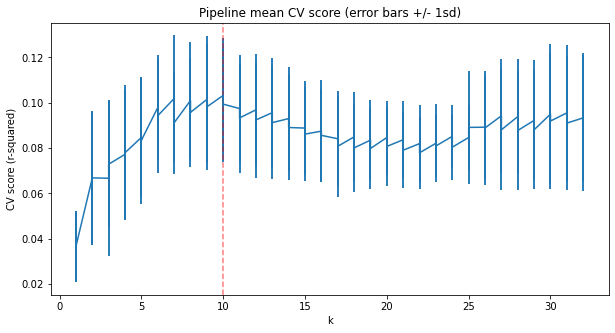

In [32]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Best Linear Model Performance Metrics

#### R-squared (COD)

In [69]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.12261537, 0.13041703, 0.09340593, 0.11038235, 0.05930985])

In [70]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.10322610427123065, 0.025264894725110305)

#### Mean Absolute Error (MAE)

In [71]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [72]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(0.5849003680398924, 0.009010178378140114)

In [73]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

0.5758155716830579

#### Mean Squared Error (MSE)

In [77]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [84]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(0.6103975977645928, 0.03517526788445067)

In [85]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

0.6178080390643891

#### Root Mean Square Error (RMSE)

In [80]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [86]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(0.7809554660324466, 0.02249795187649241)

In [87]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

0.7860076584005967

### Best Linear Model Feature Importance

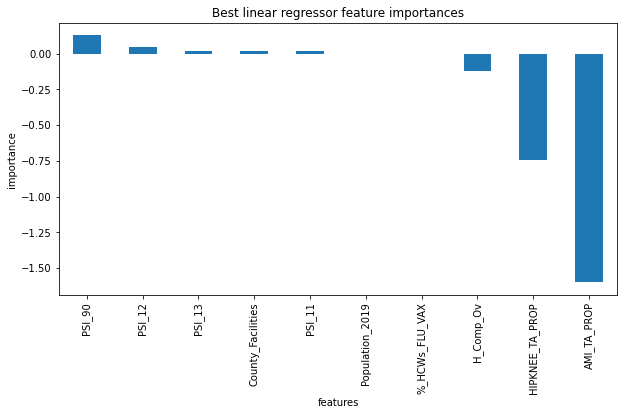

In [38]:
#Plot a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [39]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'hospital_RR_linearmodel.pkl', modelpath)

### Save Prediction Metrics from Dummy and Linear Regression Models

In [90]:
# save other data for model comparisons in machine learning model stage
comp_data_from3 = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/comp_data_from3.pickle', 'wb') as f:
    pickle.dump(comp_data_from3, f)

## Summary of Preprocessing, Training and Linear Modeling

* The final data consisted of the ~2500 US hospitals - ~65% of all hospitals in the original CMS data set- that both had available target data (Readmission Rate) and at least 200 inpatient admissions in the previous year. 


* Data were subject to a 70/30 training/testing split. 5-fold training cross validation was performed for each model described below prior to test set prediction. For each model, metrics evaluated for both cross-validation on the training set and for the test set were R-squared, MAE, MSE, and RMSE. Summarized below (and in the Modeling notebook for non-linear/ensemble models) is cross-validation RMSE (and SD thereof for the Linear Model), though each metric tracked roughly proportionately across models.


* Average Readmission Rate was first explored as a baseline measure of performance. 
  * Readmission Rate predicted simply by average price in the training set yielded a prediction that was approximately .83% off of average actual Readmission Rate in cross-validation on the training set (RMSE).


* Next a Linear Regression model was built, which was optimized in terms of K-best features (which turned out to be k = 9). In constucting this model, it was also determined that the best missing values imputation method was to use the mean and the best scaling strategy was to not use any scaling. 
    * The best Linear model yielded a prediction that was approximately .78% (.02%) off of average actual Readmission Rate in cross-validation on the training set (RMSE). 
    * Best Linear model outperformed the baseline model


* Subsequently, ('Modeling' stage) multiple decision tree-based machine learning models will be evaluated and compared to both the dummy model (prediction with average) and the best Linear Regression Model conduted at this stage. 
    * The initial plan is to first deploy Random Forest, which has one advantage of being able to see which features contributed the most to the best model prediction. Then, the plan is to evaluate andcompare the prediction quality of at least several ensemble models in this class (Gradient Boosting Regression and HistGradient Boosting Regression; possibly XBoost as well).  